In [1]:
##################################
# Download, merging and annotation
##################################

In [1]:
import GEOparse
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join


# для визуализации распределения семплов в пространстве признаков
def plot_mds(X, target, colors = ['green', 'red'], labels = ['CTRL', 'HCM']):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    mds = MDS(2,random_state=0)
    X_2d = mds.fit_transform(X_scaled)
    
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    for i in np.unique(target):
        subset = X_2d[target == i]
        x = [row[0] for row in subset]
        y = [row[1] for row in subset]
        plt.scatter(x, y, c=colors[i], label = labels[i])
    plt.legend()
    plt.show()

In [2]:
PATH = './GSE130036_RAW/'
files = [f for f in listdir(PATH) if isfile(join(PATH, f))]

seq_data = pd.DataFrame()
colnames = []

# В цикле пробегаемся по всем файлам и объединяем их в один фрейм

for file in files:
    #пропускаем системный файл
    if file == '.DS_Store':
        continue
    
    df = pd.read_csv('./GSE130036_RAW/' + file, 
                 compression='gzip', header=0, sep='\t', quotechar='"', error_bad_lines=False)
    
    df.index = df['target_id']
    colnames.append(file.split('_')[1]) #чтобы потом присвоить имена файлов столбцам
    seq_data = pd.concat([seq_data, df['tpm']], axis=1, sort=False)

seq_data.columns = colnames
seq_data['ID'] = seq_data.index

In [3]:
#аннотация
annotation = pd.read_csv('./ENSG.ENST.ENSP.Symbol.hg19.bed.txt', sep='\t', header=None)

annotation = pd.DataFrame(annotation.iloc[:,[3,5]]) #оставляем только ENST и Gene Symbol. Остальное нам не нужно
annotation.columns = ['Gene Symbol', 'ID']

seq_data_annot = seq_data.merge(annotation, left_on='ID', right_on='ID') #мерджим дату с аннотацией по ENST

In [4]:
# небольшой препроцессинг
# remove ENST without Gene Symbol
seq_data_annot = seq_data_annot.dropna(subset=['Gene Symbol'])
# for each Gene Symbol average TPM over ENST
seq_data_annot = seq_data_annot.groupby('Gene Symbol').median()

In [11]:
# формируем y и сохраняем
rnaseq_y = np.array(list((map(lambda x: 'HCM' in x, seq_data_annot.columns)))) + 0

pd.DataFrame(rnaseq_y).to_csv('./rna_seq_target.csv')
seq_data_annot.to_csv('./rna_seq_data.csv')

In [2]:
dataset_name = "GSE36961" # набор на 145 семплов

gse = GEOparse.get_GEO(dataset_name)
data_train = gse.pivot_samples('VALUE')

# вытаскиваем лейблы семплов

experiments = {}
for i, (idx, row) in enumerate(gse.phenotype_data.iterrows()):
    tmp = {}
    tmp["Experiment"] = idx
    tmp['platform_id'] = row['platform_id']
    tmp['status'] = 'HCM' if 'HCM' in row['source_name_ch1'] else 'CTRL'
    experiments[i] = tmp
experiments = pd.DataFrame(experiments).T

gsm_to_stat = dict(zip(experiments['Experiment'], experiments['status']))
data_train.columns = [gsm_to_stat[i] for i in data_train.columns]

05-Sep-2021 17:36:43 DEBUG utils - Directory ./ already exists. Skipping.
05-Sep-2021 17:36:43 INFO GEOparse - File already exist: using local version.
05-Sep-2021 17:36:43 INFO GEOparse - Parsing ./GSE36961_family.soft.gz: 
05-Sep-2021 17:36:43 DEBUG GEOparse - DATABASE: GeoMiame
05-Sep-2021 17:36:43 DEBUG GEOparse - SERIES: GSE36961
05-Sep-2021 17:36:43 DEBUG GEOparse - PLATFORM: GPL15389
05-Sep-2021 17:36:43 DEBUG GEOparse - SAMPLE: GSM907203
05-Sep-2021 17:36:43 DEBUG GEOparse - SAMPLE: GSM907204
05-Sep-2021 17:36:43 DEBUG GEOparse - SAMPLE: GSM907205
05-Sep-2021 17:36:43 DEBUG GEOparse - SAMPLE: GSM907206
05-Sep-2021 17:36:43 DEBUG GEOparse - SAMPLE: GSM907207
05-Sep-2021 17:36:43 DEBUG GEOparse - SAMPLE: GSM907208
05-Sep-2021 17:36:43 DEBUG GEOparse - SAMPLE: GSM907209
05-Sep-2021 17:36:44 DEBUG GEOparse - SAMPLE: GSM907210
05-Sep-2021 17:36:44 DEBUG GEOparse - SAMPLE: GSM907211
05-Sep-2021 17:36:44 DEBUG GEOparse - SAMPLE: GSM907212
05-Sep-2021 17:36:44 DEBUG GEOparse - SAMPLE: 

05-Sep-2021 17:36:53 DEBUG GEOparse - SAMPLE: GSM907343
05-Sep-2021 17:36:53 DEBUG GEOparse - SAMPLE: GSM907344
05-Sep-2021 17:36:53 DEBUG GEOparse - SAMPLE: GSM907345
05-Sep-2021 17:36:54 DEBUG GEOparse - SAMPLE: GSM907346
05-Sep-2021 17:36:54 DEBUG GEOparse - SAMPLE: GSM907347


In [9]:
dataset_name = "GSE1145"

gse = GEOparse.get_GEO(dataset_name)
data_test = gse.pivot_samples('VALUE')
data_test.head()

# вытаскиваем лейблы семплов

def status_extr(row):
    #print(row['title'])
    #print(row['description'].split('Keywords = ')[1], row['platform_id'])
    if 'N' in row['title']:
        return 'CTRL'
    if 'hypertrophic cardiomyopathy' in row['description'].split('Keywords = ')[1]:
        return 'HCM'
    elif 'congestive cardiomyopathy' in row['description'].split('Keywords = ')[1]:
        return 'CTRL'
    else:
        return 9999

experiments = {}
for i, (idx, row) in enumerate(gse.phenotype_data.iterrows()):
    tmp = {}
    tmp['title'] = row['title'][3:]
    tmp["Experiment"] = idx
    tmp['platform_id'] = row['platform_id']
    tmp['description'] = row['description'].split('Keywords = ')[1]
    tmp['status'] = status_extr(row)
    experiments[i] = tmp
experiments = pd.DataFrame(experiments).T

tmp_exp = experiments[experiments['status'] != 9999]#[experiments['platform_id'] == 'GPL570']

data_test = data_test.filter(tmp_exp['Experiment'])    #отбираем ту часть эксперимента, которая нам нужна, сделанная на GPL570. 
                                                    #Другая часть - исследование экспрессии микроРНК
gsm_to_stat = dict(zip(tmp_exp['Experiment'], tmp_exp['status']+'_'+tmp_exp['platform_id']))
data_test.columns = [gsm_to_stat[i] for i in data_test.columns]


05-Sep-2021 18:06:51 DEBUG utils - Directory ./ already exists. Skipping.
05-Sep-2021 18:06:51 INFO GEOparse - File already exist: using local version.
05-Sep-2021 18:06:51 INFO GEOparse - Parsing ./GSE1145_family.soft.gz: 
05-Sep-2021 18:06:51 DEBUG GEOparse - DATABASE: GeoMiame
05-Sep-2021 18:06:51 DEBUG GEOparse - SERIES: GSE1145
05-Sep-2021 18:06:51 DEBUG GEOparse - PLATFORM: GPL570
/opt/anaconda3/lib/python3.7/site-packages/GEOparse/GEOparse.py:104: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath)
05-Sep-2021 18:06:53 DEBUG GEOparse - PLATFORM: GPL8300
05-Sep-2021 18:06:53 DEBUG GEOparse - SAMPLE: GSM18422
05-Sep-2021 18:06:53 DEBUG GEOparse - SAMPLE: GSM18423
05-Sep-2021 18:06:53 DEBUG GEOparse - SAMPLE: GSM18424
05-Sep-2021 18:06:54 DEBUG GEOparse - SAMPLE: GSM18425
05-Sep-2021 18:06:54 DEBUG GEOparse - SAMPLE: GSM18426
05-Sep-2021 18:06:54 DEBUG GEOparse - SAMPLE: GSM18427
05-Sep-2021 18:06:54 DEBUG

In [10]:
def annotation(data_test, platform):
    data_test['index'] = data_test.index

    # annotate with GPL
    data_test = data_test.reset_index().merge(gse.gpls[platform].table[["ID", "Gene Symbol"]],
                                    left_on='index', right_on="ID").set_index('index')
    del data_test["ID"]
    # remove probes without ENTREZ
    data_test = data_test.dropna(subset=['Gene Symbol'])
    # remove probes with more than one gene assigned
    data_test = data_test[~data_test['Gene Symbol'].str.contains("///")]
    # for each gene average LFC over probes
    data_test = data_test.groupby('Gene Symbol').median()
    return data_test

In [11]:
#этот блок появился для расширения тестового набора стенозниками
#аннотируем отдельно данные которые были получена на чипе GPL570 и на GPL8300

# GPL570
mask_570 = np.array(list(map(lambda x: 'GPL570' in x, data_test.columns)))
data_570 = data_test.loc[:,mask_570]
data_570_annot = annotation(data_570, 'GPL570')

# GPL8300
data_8300 = data_test.loc[:,mask_570 == False]
data_8300_annot = annotation(data_8300, 'GPL8300')

# merge 
data_8300_annot['index'] = data_8300_annot.index
data_570_annot['index'] = data_570_annot.index

data_8300_570 = data_8300_annot.reset_index().merge(data_570_annot,
                                    left_on='index', right_on="index").set_index('index')

data_570_annot = data_570_annot.iloc[:,:-1] #выкидываем индекс
data_test = data_570_annot #возвращаем название для дальнейщего анализа, как это делалось ранее

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
print('test:', data_test.shape)
print('train:', data_train.shape)

# отбираем те гены, которые есть в обоих наборах
set_test = set(data_test.index)
gene_universe = set_test.intersection(data_train.index)

data_train = data_train.filter(gene_universe, axis=0)
data_test = data_test.filter(gene_universe, axis=0)

print()
print('test:', data_test.shape)
print('train:', data_train.shape)

test: (21655, 16)
train: (37846, 145)

test: (14830, 16)
train: (14830, 145)


In [7]:
class Data(object): 
    def __init__(self):
        pass
    
Data.X = Data()
Data.X.train = data_train
Data.X.test = data_test
Data.y = Data()
Data.y.train = list(map(int, Data.X.train.columns == 'HCM'))
Data.y.test = list(map(int, Data.X.test.columns == 'HCM'))

In [206]:
class Data(object): 
    def __init__(self):
        pass
    
Data.X = Data()
Data.X.train = pd.read_csv('./X_train.csv', index_col=0)
Data.X.test = pd.read_csv('./X_test_out.csv', index_col=0)
Data.y = Data()
Data.y.train = list(pd.read_csv('./y_train.csv').iloc[:,1])
Data.y.test = list(pd.read_csv('./y_test_out.csv').iloc[:,1])

In [207]:
#################################
# Feature selection
#################################

In [208]:
"""
Главная идея:

Выборка маленькая, поэтому не будем избегать влияния случайности, например фиксируя random_state, а будем пытаться эту случайность оседлать.

Как будем отбирать фичи?

1) Фичи будем отбирать на основе лог.регрессии.
        а) подберем коэффициент L1-регуляризации
        б) будем обучать 1000 моделей на бутстрепленных из X_train данных
        в) фичи, которые попали в модель, которая хоть как-то работает (coef > 0) хоть в одной работающей (roc-auc > 0.7) моделе, будем сохранять в словарик

2) Отобранные фичи упорядочим по их ценности, за которую примем произведение roc-auc модели, из которой пришла фича, coef и количества моделей, в которые фича была включена.
                                            идея: чем в большее число хорошо работающих моделей включается фича - тем она ценнее

3) Финально выберем какую-то долю из тех фичей, которые входят в топ-20 фичей упорядоченного списка

"""

'\nГлавная идея:\n\nВыборка маленькая, поэтому не будем избегать влияния случайности, например фиксируя random_state, а будем пытаться эту случайность оседлать.\n\nКак будем отбирать фичи?\n\n1) Фичи будем отбирать на основе лог.регрессии.\n        а) подберем коэффициент L1-регуляризации\n        б) будем обучать 1000 моделей на бутстрепленных из X_train данных\n        в) фичи, которые попали в модель, которая хоть как-то работает (coef > 0) хоть в одной работающей (roc-auc > 0.7) моделе, будем сохранять в словарик\n\n2) Отобранные фичи упорядочим по их ценности, за которую примем произведение roc-auc модели, из которой пришла фича, coef и количества моделей, в которые фича была включена.\n                                            идея: чем в большее число хорошо работающих моделей включается фича - тем она ценнее\n\n3) Финально выберем какую-то долю из тех фичей, которые входят в топ-20 фичей упорядоченного списка\n\n'

In [209]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model, model_selection
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
import random
from sklearn.manifold import MDS
from collections import Counter
from random import choices
from itertools import compress

roc_auc_scorer = metrics.make_scorer(metrics.roc_auc_score)
scaler = StandardScaler()

In [9]:
# train test split and scaling
X_train, X_test, y_train, y_test = train_test_split(Data.X.train.transpose(), 
                                                    Data.y.train, 
                                                    test_size=0.2, 
                                                    random_state=42)


In [10]:
C = np.array([0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01])

0
1
2
3
4


[<matplotlib.lines.Line2D at 0x7ff7575f4ed0>]

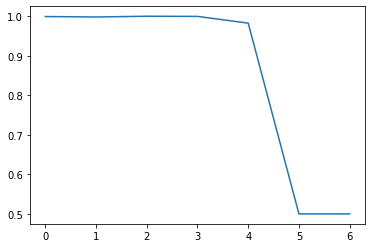

In [14]:
X_train = scaler.fit_transform(X_train)
# возвращаем имена фичей
X_train = pd.DataFrame(X_train, columns=Data.X.train.index)

# Подбираем коэффициент регуляризации. Выбираем тот, после которого всё качество идет по п*зде

result_df_train = pd.DataFrame()
result_df_test = pd.DataFrame()


# 10 раз шатаем модель по разным random_state, потом усредняем по смотрим на результат по коэффициентам

for a in range(0,5):
    print(a)
    random_state = random.randint(1,100)
    roc_auc_train = list()
    roc_auc_test = list()
    for i in C:
        linear_regressor = linear_model.LogisticRegression(penalty='l1', C=i, solver='liblinear', random_state=random_state)
        roc_auc_train.append(np.mean(cross_val_score(linear_regressor, X_train, y_train, scoring='roc_auc')))
    result_df_train[a] = roc_auc_train

plt.plot(result_df_train.apply(np.mean, axis=1))

In [217]:
class FeatureExtraction(object):
    
    """
    Класс для экстракции фичей. Главная идея не фиксировать случайность, а оседлать её :)
    
    """
    
    
    def __init__(self):
        pass
        
    def fit(self, n_iter, X_train, y_train, X_test, y_test, C=0.03):
        
        """
        Будем n_iter раз бутстрепить сбалансированную train выборку из X_train.
        Обучаем лог.рег. с L1-решуляризацией, с коэффициентом как мы отобрали выше.
        Тестим на X_test, значение добавляем в roc_auc_list
        
        Если на X_test модель работает круче 0.7, то: 
            1) ненулевые фичи модели добавляем в словарик отобранных фичей feature_dict
            2) обновляем число фичей в перменной len_best_feature = len(feature_dict.keys())
        Если нет, то:
            3) дублируем последнее значение в len_best_feature, т.к. число фичей не изменилось
        """
        
        len_best_feature = [0] # заводим лист, в котором будем отслеживать изменение количества фичей
        len_best_more_one = [0] # заводим лист, в котором будем отслеживать изменение количества числа включений уже включенных фичей
        roc_auc_list = list() # аналогично, отслеживаем как меняется roc-auc, так для интереса
        feature_dict = dict() # # словарь "ген: log.reg.coef"
        
        
        for i in range(0, n_iter):

            # чтобы получить сбаланнсированную выборку, бутстрепим отдельно семплы из контроля и из опыта

            mask = np.array(y_train) == 0
            
            k_len = min(len(mask)-sum(mask), sum(mask)) #размер выборки бутстрепа, берем размер минимальной группы HCM или CTRL

            CTRL_rows = list(compress(range(0, len(mask)), mask))
            HCM_rows = list(compress(range(0, len(mask)), mask == False))

            _HCM_rows = choices(HCM_rows, k=k_len) # бутстрепим номера строк из группы больных
            _CTRL_rows = choices(CTRL_rows, k=k_len) # бутстрепим номера строк из группы здоровых

            # объединяем это всё дело обратно

            _X_train = pd.DataFrame(X_train).iloc[_HCM_rows + _CTRL_rows,:]
            _y_train = np.array(y_train)[_HCM_rows + _CTRL_rows]

            # обучаем лог.рег. с ранее отобранным коэффициентом регуляризации

            linear_regressor = linear_model.LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                                               random_state=42)
            linear_regressor.fit(_X_train, _y_train)

            # тестим

            roc_auc = metrics.roc_auc_score(y_score=linear_regressor.predict(X_test), y_true=y_test)
            roc_auc_list.append(roc_auc)

            # далее отбираем фичи из моделей, которые хоть как-то работают (roc_auc > 0.7)

            if roc_auc > 0.7:
                # отбираем смысловые фичи
                mask = linear_regressor.coef_ != 0 
                genes = X_train.columns[mask[0]]
                values = linear_regressor.coef_[mask]

                _feature_dict = dict(zip(genes, abs(values)*roc_auc)) #делаем временный словарь "ген: его ценность"

                # обнавляем глобальный словарь фичей
                for gene, values in _feature_dict.items():
                    if gene in feature_dict:
                        feature_dict[gene].append(values)
                    else:
                        feature_dict[gene] = [values]

                len_best_feature.append(len(feature_dict.keys()))
                
                feature_distr = np.array(list(map(lambda x: len(feature_dict[x]), feature_dict)))
                len_best_more_one.append(sum(feature_distr[feature_distr > 1]))
            
            else:
                # если модель была говёной, то просто дублируем предыдущее значение. Ну, число фичей то не изменилось :)
                len_best_feature.append(len_best_feature[-1])
                len_best_more_one.append(len_best_more_one[-1]) 
        
        
        
        self.len_best_more_one = np.array(len_best_more_one)
        self.len_best_feature = np.array(len_best_feature)
        self.feature_dict = feature_dict
        self.roc_auc_list = roc_auc_list
    

In [225]:
# Исходное разбиение, _test не трогаем
X_train, X_test, y_train, y_test = train_test_split(Data.X.train.transpose(), 
                                                    Data.y.train, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [229]:
# некоторые функции для нижеследующего

scaler = StandardScaler(with_mean = False)
normalizer = Normalizer()

def standard_scaler_row(X):
    colnames = X.columns
    return pd.DataFrame(scaler.fit_transform(X.transpose()).transpose(), columns= colnames)

def l2_normalisation(X):
    colnames = X.columns
    return pd.DataFrame(normalizer.fit_transform(X), columns=colnames)

def class_chek(y):
    y = np.array(y)
    if sum(y == 0) == len(y):
        return(1)
    elif sum(y == 1) == len(y):
        return(1)
    else:
        return(0)

In [230]:
scaler = StandardScaler(with_mean = False)
normalizer = Normalizer()
X_train = standard_scaler_row(l2_normalisation(X_train))
X_test = standard_scaler_row(l2_normalisation(X_test))

df_bmo = list()
df_bf = list()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# возвращаем имена фичей
X_train = pd.DataFrame(X_train, columns=Data.X.train.index)
X_test = pd.DataFrame(X_test, columns=Data.X.train.index)


for i in range(0,5):
    print(i)
    fe = FeatureExtraction()
    fe.fit(500, X_train, y_train, X_test, y_test)
    df_bmo.append(fe.len_best_more_one)
    df_bf.append(fe.len_best_feature)

0
1
2
3
4


[<matplotlib.lines.Line2D at 0x7ff0842f80d0>]

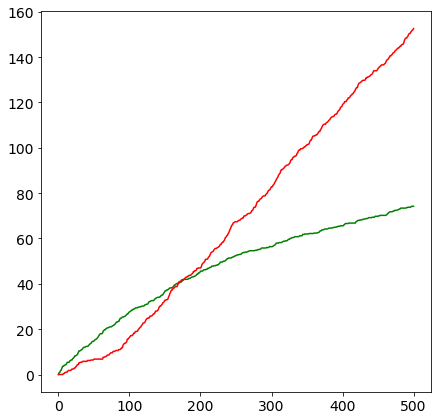

In [231]:
#посмотрим, как с каждой итерацией нарастают фичи

plt.plot(pd.DataFrame(df_bf).mean(), 'green') #прирост новых фичей
plt.plot(pd.DataFrame(df_bmo).mean(), 'red') #прирост фичей, которые уже встречались

In [232]:
"""
Идея: повторим экстракцию фичей 50 раз (вычислительно емко получается для ноутбучика), 
отсортируем каждый из получившихся наборов по важности фичей, найдем размер окна для отбора n-топ фичей, 
в котором состав фичей минимально изменяется от набора к набору. А потом отберем те фичи, которые всегда встречаются в окне этого размера.
"""

list_feature_dicts = list()

for i in range(0,20):
    print(i)
    # train_test split and transformation
    X_train, X_test, y_train, y_test = train_test_split(Data.X.train.transpose(), 
                                                        Data.y.train, 
                                                        test_size=0.2, 
                                                        random_state=i)
    if class_chek(y_train):
        continue
    if class_chek(y_test):
        continue
    
    scaler = StandardScaler(with_mean = False)
    normalizer = Normalizer()
    
    X_train = standard_scaler_row(l2_normalisation(X_train))
    X_test = standard_scaler_row(l2_normalisation(X_test))
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # возвращаем имена фичей
    X_train = pd.DataFrame(X_train, columns=Data.X.train.index)
    X_test = pd.DataFrame(X_test, columns=Data.X.train.index)
    
    # отбор фичей
    fe = FeatureExtraction()
    fe.fit(200, 
           X_train, y_train, X_test, y_test)
    list_feature_dicts.append(fe.feature_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [233]:
lfd = list_feature_dicts

[<matplotlib.lines.Line2D at 0x7ff08271bf10>]

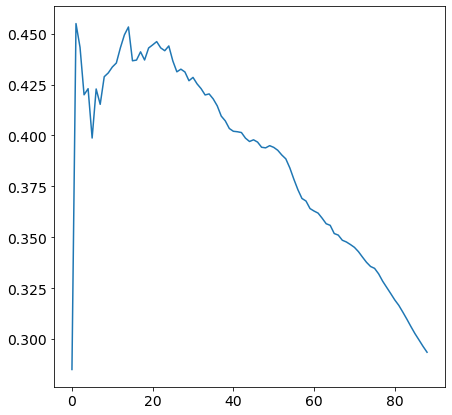

In [234]:
#сортируем фичи в порядке убывания их значимости
#значимость считаем как (число включений в моедль)

lfd_sort = list()
for d in lfd:
    lfd_sort.append(dict(sorted(d.items(), key=lambda item: len(item[1]), reverse=True)))

"""
Идея:

Хотим выбрать топ n генов, который минимально изменяется от набора в lfd к набору (с точностью до перестановки). 
Очевидно 1 < n < минимального набора генов.

"""

result = list()

max_len = max(list(map(lambda x: len(x.keys()), lfd_sort))) # минимальная длина словаря feature_dict 

for yeld in range(1, max_len):
    
    similarity = np.zeros((len(lfd_sort),len(lfd_sort)))
    
    for i in range(0,len(lfd_sort)):
        
        one = list(lfd_sort[i].keys())
        if len(one) < max_len:
            one = one + [i for i in range(0,max_len-len(one))]
            
        for j in range(0,len(lfd_sort)):
            two = list(lfd_sort[j].keys())
            if len(one) < max_len:
                two = two + [i for i in range(0,max_len-len(two))]
            
            one_set = set(one[:yeld])
            two_set = set(two[:yeld])
            sim = len(one_set.intersection(two_set))/yeld
            similarity[i,j] = sim
    
    result.append(np.mean(similarity))

plt.plot(result)

In [240]:
result[20:30] == max(result[20:30])

array([False,  True, False, False, False, False, False, False, False,
       False])

AP3M2 CDC42EP4 CEBPD FCN3 MT1M MYH6 RASD1 SERPINA3 ZFP36


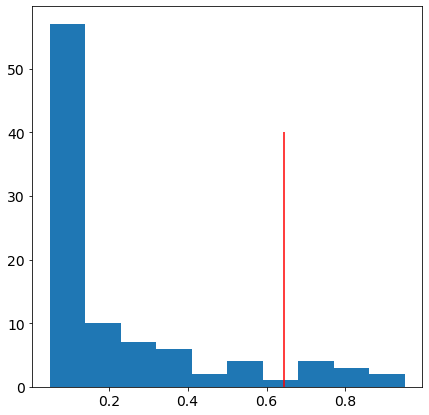

In [245]:
#отбираем гены, которые всегда занимают в словарях первые n мест
TOP = 21

top_gene_list = map(lambda x: list(x.keys())[:TOP], lfd_sort)

top_gene = set()
for i in top_gene_list:
    top_gene.update(i)

# посчитаем gene_weight, как долю моделей, где gene находится на первых n-местах

gene_weight = dict()
for gene in top_gene:
    value = sum(list(map(lambda x: gene in list(x.keys())[:TOP], lfd_sort)))/len(lfd_sort)
    gene_weight[gene] = value

q_prob = np.quantile(list(gene_weight.values()), 0.91)
best_features = [k for k in gene_weight.keys() if gene_weight[k] > q_prob]
plt.hist(gene_weight.values())
plt.vlines(q_prob, 0, 40, 'red')
print(*sorted(best_features))

In [247]:
# удаляем фичи, которые были включены только в одну модель, как сказали выше - это мусор

for i in range(0, len(lfd)):
    d = lfd[i]
    lfd[i] = {k : v for k, v in d.items() if len(v)>1}

gene_universe = set() #множество всех рассматриваемых генов
for i in range(0, len(lfd)):
    gene_universe.update(lfd[i].keys())

gene_weight = dict()
for gene in gene_universe:
    value = sum(list(map(lambda x: gene in list(x.keys()), lfd)))/len(lfd)
    gene_weight[gene] = value

AP3M2 CDC42EP4 CEBPD CHN1 FCN3 MT1M MYH6 RASD1 SERPINA3 ZFP36

CDC42EP4 CEBPD FCN3 MT1X MYH6 PRKCD PROS1 ZFP36


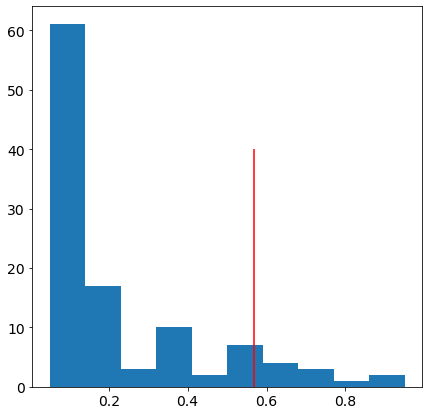

In [248]:
q_prob = np.quantile(list(gene_weight.values()), 0.91)
best_features = [k for k in gene_weight.keys() if gene_weight[k] > q_prob]
plt.hist(gene_weight.values())
plt.vlines(q_prob, 0, 40, 'red')
print(*sorted(best_features))
print()
print(*sorted(['FCN3', 'MT1X', 'PROS1', 'MYH6', 'CDC42EP4', 'ZFP36', 'PRKCD', 'CEBPD']))

MYH6 MT1M FCN3 RASD1 CEBPD CDC42EP4 PRKCD

FCN3 MT1X PROS1 MYH6 CDC42EP4 ZFP36 PRKCD CEBPD


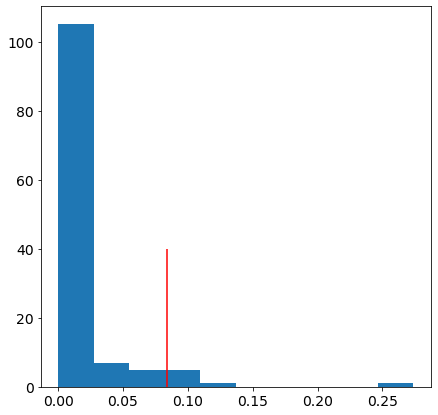

In [525]:
plt.hist(gene_weight.values())
plt.vlines(q_prob, 0, 40, 'red')
print(*best_features)
print()
print(*['FCN3', 'MT1X', 'PROS1', 'MYH6', 'CDC42EP4', 'ZFP36', 'PRKCD', 'CEBPD'])

In [ ]:
#################################
# model train
#################################

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import Normalizer

# для визуализации распределения семплов в пространстве признаков
def plot_mds(X, target, colors = ['green', 'red'], labels = ['CTRL', 'HCM']):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    mds = MDS(2, random_state=42)
    X_2d = mds.fit_transform(X_scaled)
    
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    for i in np.unique(target):
        subset = X_2d[target == i]
        x = [row[0] for row in subset]
        y = [row[1] for row in subset]
        plt.scatter(x, y, c=colors[i], label = labels[i])
    plt.legend()
    plt.show()

scaler = StandardScaler()
normalizer = Normalizer(norm = 'max')

def StandartScaling(X):
    
    scaler = StandardScaler()
    """
    X - matrix, features in columns, samples in rows
    """
    
    colnames = X.columns 
    X = X.transpose()   # StandardScaler работает по столбцам, поэтому транспонируем, чтобы в столбцах оказались семплы
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X.transpose(), columns=colnames)
    return(X)

In [821]:
X = pd.read_csv('./X_train.csv', index_col=0).transpose()
X_test_out = pd.read_csv('./X_test_out.csv', index_col=0).transpose()
X_test_out_extension = pd.read_csv('./X_test_out_extension.csv', index_col=0).transpose()

y = list(pd.read_csv('./y_train.csv').iloc[:,1])
y_test_out = list(pd.read_csv('./y_test_out.csv').iloc[:,1])
y_test_out_extension = list(pd.read_csv('./y_test_out_extension.csv').iloc[:,1])

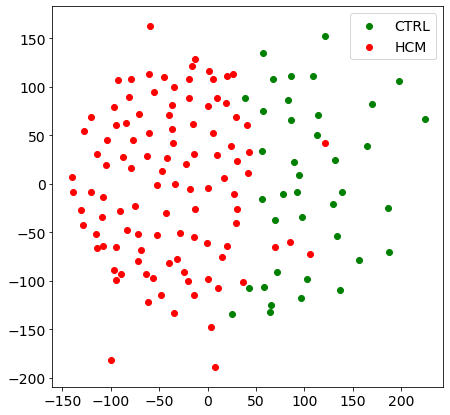

In [822]:
plot_mds(X, y)

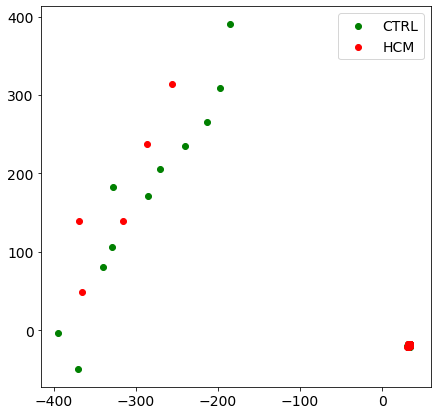

In [823]:
plot_mds(pd.concat([X_test_out, X]), y_test_out + y)

In [440]:
#best_features = ['FCN3', 'MT1X', 'PROS1', 'MYH6', 'CDC42EP4', 'ZFP36', 'PRKCD', 'LYVE1', 'CEBPD', 'MT1M', 'RASD1', 'S1PR3']
#best_features = ['FCN3', 'MT1X', 'PROS1', 'MYH6', 'CDC42EP4', 'ZFP36', 'PRKCD', 'CEBPD']
best_features = ['MYH6', 'MT1M', 'FCN3', 'RASD1', 'CEBPD', 'CDC42EP4', 'PRKCD']
best_features = ['AP3M2', 'CDC42EP4', 'CEBPD', 'FCN3', 'MT1M', 'MYH6', 'RASD1', 'SERPINA3', 'ZFP36']

#X = Data.X.train.transpose().filter(best_features, axis=1)
#X_test_out = Data.X.test.transpose().filter(best_features, axis=1)
#y = Data.y.train
#y_test_out = Data.y.test

X = pd.read_csv('./X_train.csv', index_col=0).transpose().filter(best_features, axis=1)
X_test_out = pd.read_csv('./X_test_out.csv', index_col=0).transpose().filter(best_features, axis=1)
X_test_out_extension = pd.read_csv('./X_test_out_extension.csv', index_col=0).transpose().filter(best_features, axis=1)

X_test_out = rnaseq_data.filter(best_features, axis=1)

y = list(pd.read_csv('./y_train.csv').iloc[:,1])
y_test_out = list(pd.read_csv('./y_test_out.csv').iloc[:,1])
y_test_out_extension = list(pd.read_csv('./y_test_out_extension.csv').iloc[:,1])

y_test_out = rnaseq_y

# этих фичей не хватает в расширенном наборе, т.к. стенозники делались на другой платформе
#X_test_out_extension['LYVE1'] = 0 
#X_test_out_extension['MT1M'] = 0
#X_test_out_extension['RASD1'] = 0
#X_test_out_extension['S1PR3'] = 0

print(X.shape, X_test_out.shape, X_test_out_extension.shape)

(145, 9) (37, 9) (33, 7)


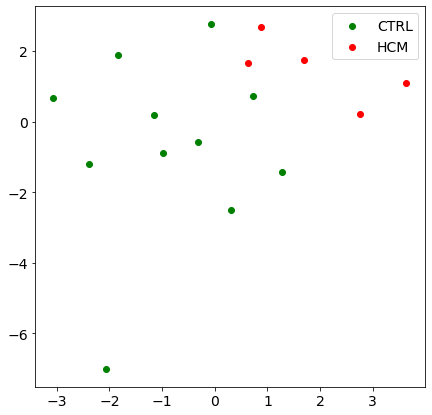

In [825]:
plot_mds(X_test_out, y_test_out)

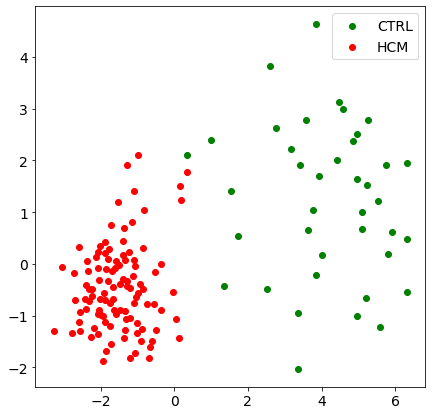

In [826]:
plot_mds(X, y)

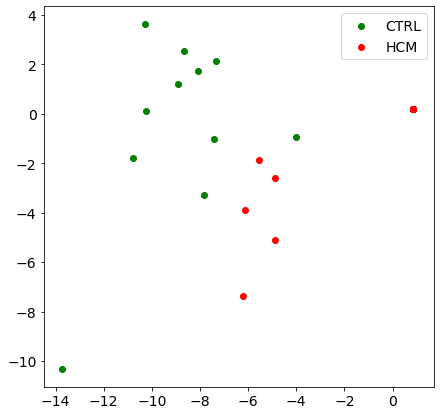

In [827]:
plot_mds(pd.concat([X, X_test_out]), y + y_test_out)

In [442]:
colnames = X.columns
X_norm = pd.DataFrame(normalizer.fit_transform(X), columns=colnames)
X_test_out_norm = pd.DataFrame(normalizer.fit_transform(X_test_out), columns=colnames)
plot_mds(pd.concat([X_norm, X_test_out]), y + y_test_out)

ValueError: operands could not be broadcast together with shapes (145,) (37,) 

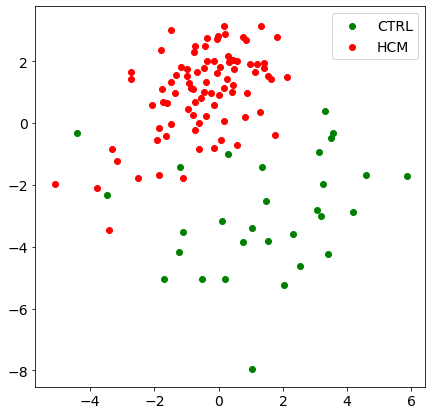

In [292]:
plot_mds(pd.concat([X_train]), y_train)

In [153]:
print(X_test_out_extension.shape)
print(X_train.shape)
print(len(y_test_out))
print(len(y_train))

(33, 7)
(116, 7)
16
116


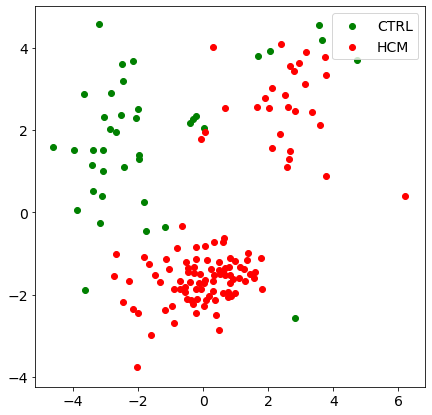

In [458]:
plot_mds(pd.concat([X_train, X_test_out]), y_train + list(y_test_out))

In [456]:
scaler = StandardScaler()
normalizer = Normalizer()

def standard_scaler_row(X):
    colnames = X.columns
    return pd.DataFrame(scaler.fit_transform(X.transpose()).transpose(), columns= colnames)

def l2_normalisation(X):
    colnames = X.columns
    return pd.DataFrame(normalizer.fit_transform(X), columns=colnames)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_out = standard_scaler_row((X_test_out))
X_train = standard_scaler_row((X_train))
X_test = standard_scaler_row((X_test))


In [444]:
rf_params = {'random_state': 42, 'n_estimators': 50, 'max_samples': 0.3, 'max_features': 'auto', 
             'max_depth': 9, 'class_weight': 'balanced', 'bootstrap': 'True'}

estimators = [
    ('rf', make_pipeline(#Normalizer(),
                         #StandardScaler(),
                         RandomForestClassifier(**rf_params))),
    ('logreg', make_pipeline(#Normalizer(),
                             #StandardScaler(),
                             LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', 
                                                penalty='l2', C=1)))
     ]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=LogisticRegression(penalty='l2', C=1), 
                         passthrough = False)

In [445]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clfStack = clf.fit(X_train, y_train)

print("train:", metrics.roc_auc_score(y_score=clfStack.predict(X_train), 
                                      y_true=y_train))
print('test_in:', metrics.roc_auc_score(y_score=clfStack.predict(X_test), 
                                           y_true=y_test))
print("test_out:", metrics.roc_auc_score(y_score=clfStack.predict(X_test_out), 
                                     y_true=y_test_out))
#print("test_out_ext:", metrics.roc_auc_score(y_score=clfStack.predict(X_test_out_extension), 
#                                     y_true=y_test_out_extension))

train: 1.0
test_in: 0.9444444444444444
test_out: 0.9464285714285714


1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 train
1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 test


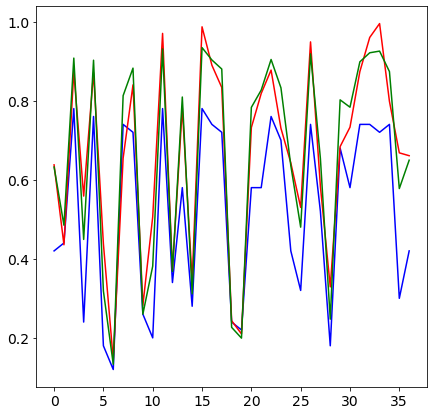

In [446]:
plt.plot(clf.estimators_[0].predict_proba(X_test_out)[:,1], 'blue')
plt.plot(clf.estimators_[1].predict_proba(X_test_out)[:,1], 'red')
plt.plot(clf.predict_proba(X_test_out)[:,1], 'green')
print(*list(clf.predict(X_test_out)), 'train')
print(*y_test_out, 'test')

In [290]:
import xgboost as xgb

In [291]:
param_dist = {'objective':'binary:logistic', 
              'n_estimators':2000, 
              'max_depth': 8, 
              'learning_rate': 0.1, 
              'subsample': 0.5, 
              'scale_pos_weight': 0.2}

norm = Normalizer()
X_train_n = pd.DataFrame(norm.fit_transform(X_train), columns=X_train.columns)
X_test_n = pd.DataFrame(norm.fit_transform(X_test), columns=X_test.columns)
X_test_out_n = pd.DataFrame(norm.fit_transform(X_test_out), columns=X_test_out.columns)

clf = xgb.XGBModel(**param_dist)

clf.fit(X_train_n, y_train,
        eval_set=[(X_train_n, y_train), (X_test_n, y_test), (X_test_out_n, y_test_out)],
        eval_metric='auc',
        verbose=True)

evals_result = clf.evals_result()

[0]	validation_0-auc:0.99419	validation_1-auc:0.94444	validation_2-auc:0.50000
[1]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[2]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[3]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[4]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[5]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[6]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[7]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[8]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[9]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[10]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[11]	validation_0-auc:1.00000	validation_1-auc:0.94444	validation_2-auc:0.50000
[12]	validation_0-auc:1.00000	validation_1-auc:0.9

[103]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[104]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[105]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[106]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[107]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[108]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[109]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[110]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[111]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[112]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[113]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[114]	validation_0-auc:1.00000	validation_1-auc:0.93889	validation_2-auc:0.27273
[115]	validation_0-auc:1.000

[205]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[206]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[207]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[208]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[209]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[210]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[211]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[212]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[213]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[214]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[215]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[216]	validation_0-auc:1.00000	validation_1-auc:0.98611	validation_2-auc:0.23636
[217]	validation_0-auc:1.000

[307]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[308]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[309]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[310]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[311]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[312]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[313]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[314]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[315]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[316]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[317]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[318]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[319]	validation_0-auc:1.000

[409]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[410]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[411]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[412]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[413]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[414]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[415]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[416]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[417]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[418]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[419]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[420]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[421]	validation_0-auc:1.000

[511]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[512]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[513]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[514]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[515]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[516]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[517]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[518]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[519]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[520]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[521]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[522]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[523]	validation_0-auc:1.000

[613]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[614]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[615]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[616]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[617]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[618]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[619]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[620]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[621]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[622]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[623]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[624]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[625]	validation_0-auc:1.000

[715]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[716]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[717]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[718]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[719]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[720]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[721]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[722]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[723]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[724]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[725]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[726]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[727]	validation_0-auc:1.000

[817]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[818]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[819]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[820]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[821]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[822]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[823]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[824]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[825]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[826]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[827]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[828]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[829]	validation_0-auc:1.000

[919]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[920]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[921]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[922]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[923]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[924]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[925]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[926]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[927]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[928]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[929]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[930]	validation_0-auc:1.00000	validation_1-auc:0.98889	validation_2-auc:0.18182
[931]	validation_0-auc:1.000

[1020]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1021]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1022]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1023]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1024]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1025]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1026]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1027]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1028]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1029]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1030]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1031]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1032]	validatio

[1120]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1121]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1122]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1123]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1124]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1125]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1126]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1127]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1128]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1129]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1130]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1131]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1132]	validatio

[1220]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1221]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1222]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1223]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1224]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1225]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1226]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1227]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1228]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1229]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1230]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1231]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1232]	validatio

[1320]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1321]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1322]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1323]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1324]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1325]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1326]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1327]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1328]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1329]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1330]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1331]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1332]	validatio

[1420]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1421]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1422]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1423]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1424]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1425]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1426]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1427]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1428]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1429]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1430]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1431]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1432]	validatio

[1520]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1521]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1522]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1523]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1524]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1525]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1526]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1527]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1528]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1529]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1530]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1531]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1532]	validatio

[1620]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1621]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1622]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1623]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1624]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1625]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1626]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1627]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1628]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1629]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1630]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1631]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1632]	validatio

[1720]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1721]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1722]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1723]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1724]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1725]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1726]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1727]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1728]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1729]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1730]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1731]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1732]	validatio

[1820]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1821]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1822]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1823]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1824]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1825]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1826]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1827]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1828]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1829]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1830]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1831]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1832]	validatio

[1920]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1921]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1922]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1923]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1924]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1925]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1926]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1927]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1928]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1929]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1930]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1931]	validation_0-auc:1.00000	validation_1-auc:0.99444	validation_2-auc:0.07273
[1932]	validatio

In [583]:
plt.plot(clf.estimators_[0].predict_proba(X_test_out)[:,1], 'blue')
plt.plot(clf.estimators_[1].predict_proba(X_test_out)[:,1], 'red')
plt.plot(clf.predict_proba(X_test_out)[:,1], 'green')
print(*list(clf.predict(X_test_out)), 'train')
print(*y_test_out, 'test')

AttributeError: 'StackingClassifier' object has no attribute 'estimators_'

In [12]:
#################################
# interpretaion
#################################

In [13]:
import shap

In [14]:
X_train_summary = shap.kmeans(X_train, 10)
ex = shap.KernelExplainer(clfStack.predict, X_train_summary)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


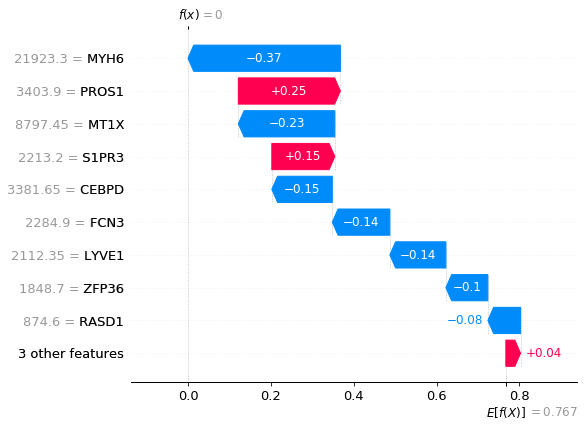

In [33]:
shap.initjs()
shap_values = ex.shap_values(X_test_out.iloc[9,:])
shap.plots.waterfall.waterfall_plot(ex.expected_value, shap_values, X_test_out.iloc[9,:])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


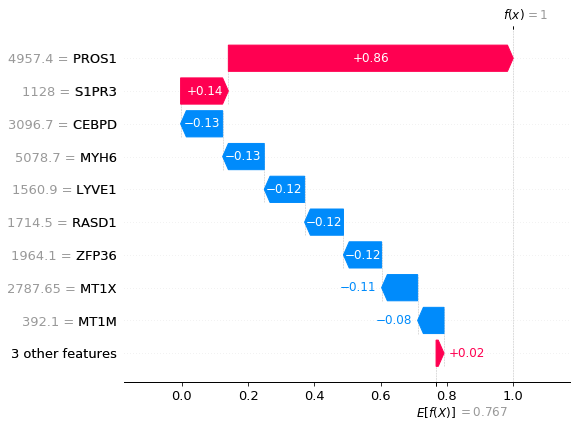

In [34]:
shap.initjs()
shap_values = ex.shap_values(X_test_out.iloc[13,:])
shap.plots.waterfall.waterfall_plot(ex.expected_value, shap_values, X_test_out.iloc[13,:])

In [32]:
shap.initjs()
shap_values = ex.shap_values(X_test_out)
shap.force_plot(ex.expected_value, shap_values, X_test_out)

  0%|          | 0/16 [00:00<?, ?it/s]

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

In [16]:
def shap_plot(X, y, shap_values):

    spdf = pd.DataFrame(shap_values[np.array(y) != 1,:], columns=X.columns)

    spdf_ctrl = pd.DataFrame(spdf.sum(axis=0), columns=['CTRL'])

    spdf_hcn = pd.DataFrame(shap_values[np.array(y) == 1,:], columns=X.columns)
    spdf_hcn = pd.DataFrame(spdf_hcn.sum(axis=0), columns=['HCM'])

    spdf = pd.concat([spdf_hcn, spdf_ctrl], axis=1)

    x = spdf['CTRL']
    y = spdf['HCM']

    plt.figure(figsize=(13,13))
    plt.scatter(x, y)
    plt.axvline(0)
    plt.axhline(0)
    plt.xlabel('CTRL SHAPE value')
    plt.ylabel('HCM SHAPE value')
    for i, txt in enumerate(spdf.index):
        plt.annotate(txt, (x[i], y[i]))

    return(spdf)
    #plt.savefig('./shape_by_gene.png', dpi = 300)

  0%|          | 0/16 [00:00<?, ?it/s]

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

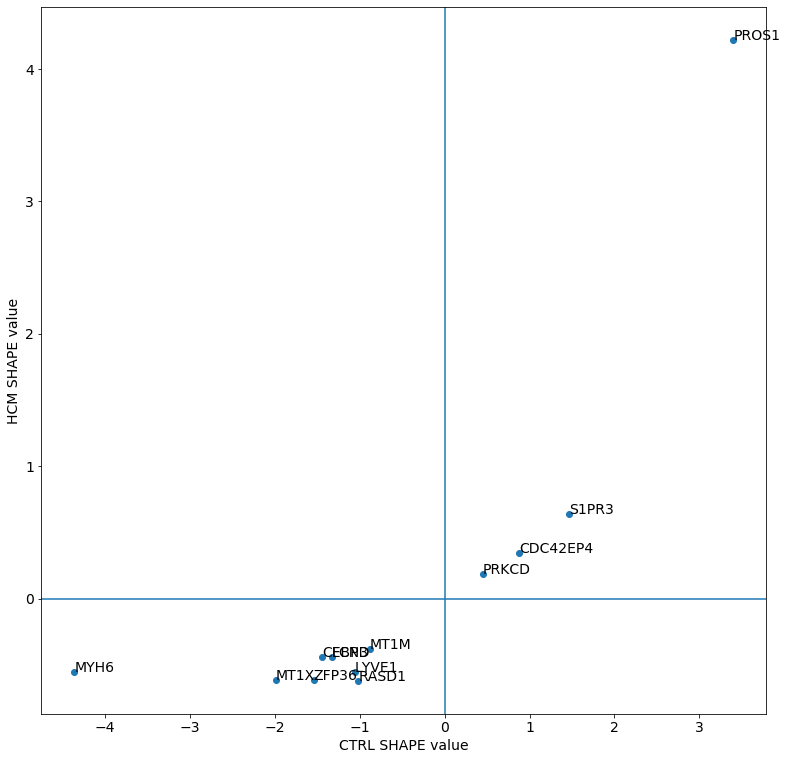

In [31]:
shap_values = ex.shap_values(X_test_out)
spdf = shap_plot(X_test_out, y_test_out, shap_values)
spdf.to_csv('../best_genes_SHAPE_distance.csv')

In [21]:
#################################
# reactome 
#################################

In [37]:
print(*best_features, sep=', ')

FCN3, MT1X, PROS1, MYH6, CDC42EP4, ZFP36, PRKCD, LYVE1, CEBPD, MT1M, RASD1, S1PR3


In [43]:
import json

In [44]:
f = open('../Data/ReactomePathways.gmt', 'r')

Reactome_path = dict()
for i in f:
    line = i.rstrip('\n').split('\t')
    Reactome_path[line[1]] = {'name': line[0], 
                           'genes': line[2:]}

In [45]:
def grep_path_ID(x, gene):
    if gene in Reactome_path[x]['genes']:
        return x

gene_to_path = dict()
for gene in best_features:
    _paths = np.array(list(map(lambda x: grep_path_ID(x, gene=gene), Reactome_path.keys())))
    
    _paths = list(_paths[_paths != None])
    
    gene_to_path[gene] = dict()
    
    if len(_paths) != 0:
    
        for path in _paths:
            if len(Reactome_path[path]['genes']) < 500:
                gene_to_path[gene][path] = Reactome_path[path]['genes']

In [26]:
with open('../Data/best_gene_to_path.json', 'w') as outfile:
    json.dump(gene_to_path, outfile)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd3ce19910>,
      dtype=object)

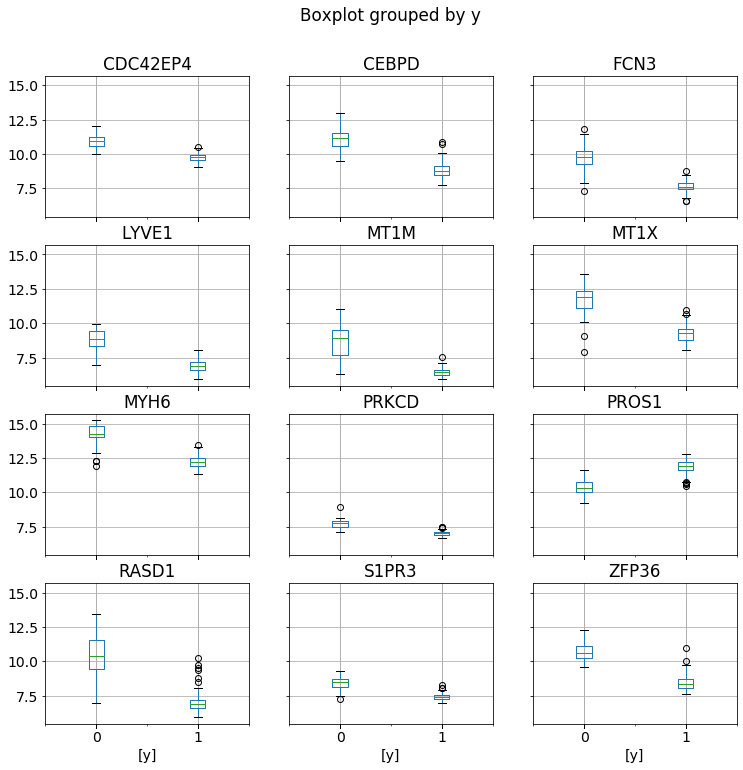

In [40]:
data = X
data['y'] = y
data.head()
data.boxplot(by='y', figsize=(12,12))

In [262]:
ATG = Reactome_path['R-HSA-9612973']['genes']

ATG = Reactome_path['R-HSA-5205647']['genes']

ATG = ['LC3II', 'BECN1', 'BCL2', 'BAX', 'CASP3']

In [263]:
X = pd.read_csv('./X_train.csv', index_col=0).transpose()

In [240]:
colnames = X.columns
normalizer = Normalizer()
data = pd.DataFrame(normalizer.fit_transform(np.log(X)), columns=colnames)

In [241]:
data = pd.DataFrame(data.transpose())

In [242]:
data.to_csv('./for_Reactome_GSEA.csv')

In [247]:
np.array(data.columns)[np.array(y)==0]

array([106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144])

In [264]:
X_ATG = np.log(X.loc[:,list(map(lambda x: x in ATG, X.columns))])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd0bdfc210>,
      dtype=object)

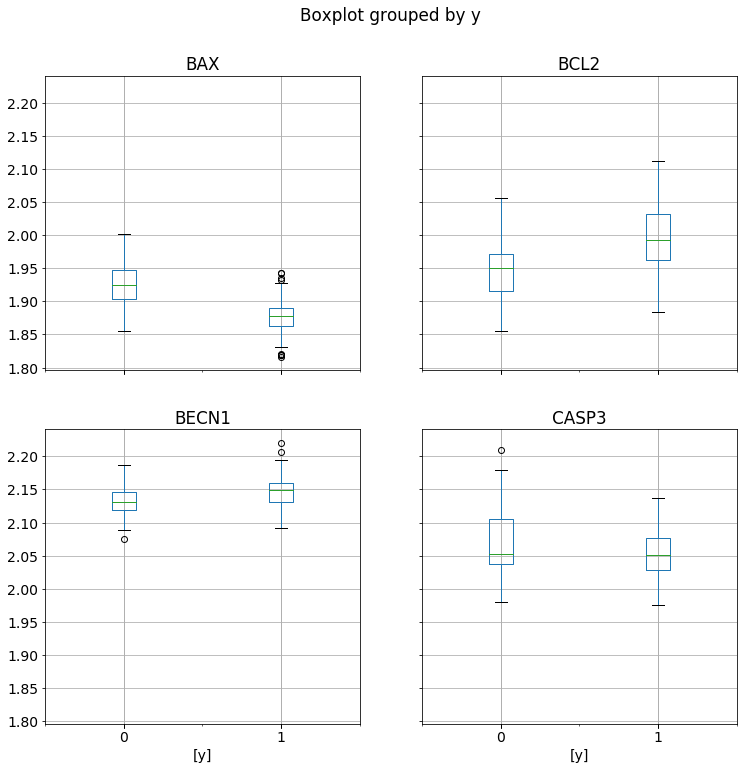

In [265]:
X_ATG['y'] = y
X_ATG.boxplot(by='y', figsize=(12,12)) 

In [270]:
pvalues = list()
for i in range(0,X_ATG.shape[1]-1):
    pvalue = stats.wilcoxon(X_ATG.iloc[:,i][np.array(y)==1][0:39], X_ATG.iloc[:,i][np.array(y)==0]).pvalue
    pvalues.append(pvalue)
    
pvalues_adj = multi.multipletests(pvalues, method='fdr_bh')[1]

In [198]:
import statsmodels.stats.multitest as multi

In [273]:
list(zip(X_ATG.columns, pvalues_adj))

[('BECN1', 0.022691528801486407),
 ('BCL2', 5.131492843088875e-06),
 ('BAX', 3.123793014241283e-06),
 ('CASP3', 0.4595337043249743)]

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([3.12379301e-06, 4.59561818e-02, 9.19092399e-02, 1.37862298e-01,
        1.83815356e-01, 2.29768414e-01, 2.75721472e-01, 3.21674530e-01,
        3.67627588e-01, 4.13580646e-01, 4.59533704e-01]),
 <a list of 10 Patch objects>)

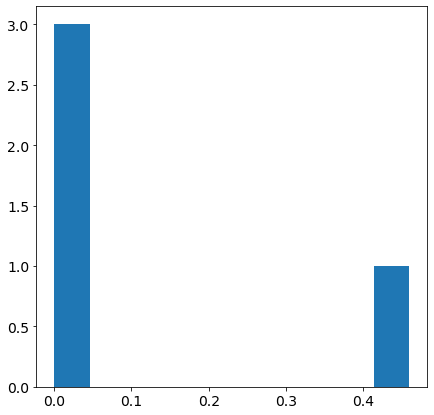

In [272]:
plt.hist(pvalues_adj)

In [211]:
np.array(X_ATG.columns)[np.array(pvalues_adj) < 0.05]

array(['APOB', 'APOA1', 'GSN', 'AKR1C4', 'GNB1', 'AGRN', 'SDC2', 'MYO1C',
       'OR51E1', 'EPB41L1', 'AKR1B10', 'RDH10', 'PDE6A', 'MYH9', 'KCNMA1',
       'RDH5', 'GUCA1C', 'SPTAN1', 'MSN', 'AKR1C3', 'METAP2', 'CTBP2',
       'GPC1', 'XIRP2', 'PDE6B', 'SPTBN1', 'LRP8', 'EPB41L3', 'DHRS3',
       'FAM65B', 'APOE', 'LDLR', 'GRK4', 'TMIE', 'GUCA1B', 'RETSAT',
       'NMT1', 'KCNMB1', 'CAPZB', 'GPIHBP1', 'NAPEPLD', 'MYO7A', 'DNAJC5',
       'CABP1', 'PRKCQ', 'RBP1', 'GNAT1', 'APOM'], dtype=object)

In [115]:
np.array(X_ATG.columns)[np.array(pvalues) < 0.05]

array(['PRKAA2', 'PCNT', 'PARK7', 'ATG7', 'GABARAP', 'MAP1LC3A',
       'CSNK2A1', 'WDR45', 'VPS37C', 'RRAGB', 'DYNLL1', 'VPS37A',
       'PIK3R4', 'MFN2', 'GABARAPL1', 'CHMP4B', 'ATG4C', 'TOMM40',
       'MTMR3', 'HSF1', 'DYNC1LI2', 'CHMP2A', 'BECN1', 'ATG4D', 'RNASE1',
       'RRAGD', 'FUNDC1', 'HBB', 'DYNC1H1', 'ATG4B', 'UBAP1', 'ULK1',
       'RB1CC1', 'IFT88', 'TSC1', 'ATG5', 'RHEB', 'CSNK2A2', 'GABARAPL2',
       'PGAM5', 'VDAC1', 'WIPI1', 'CHMP7', 'VPS37B', 'MTMR14', 'VPS37D',
       'UBC', 'PRKAG1', 'MAP1LC3B', 'EPAS1', 'DYNC1LI1', 'UBB', 'ATM',
       'PRKAB2', 'ATG10', 'VCP'], dtype=object)